In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm

sns.set()


In [2]:
def switchpoint(data,country):
    
    
    alpha = 1 / pm.Normal('alpha',mu=data.median(),tau = 1 / data.std() ** 2)

    try:
        lambda_1 = pm.Exponential('lambda_1',alpha)
    except:
        print ('cant assign priors to {}'.format(country))
        return None
    
    lambda_2 = pm.Exponential('lambda_2',alpha)
    lambda_3 = pm.Exponential('lambda_3',alpha)

    obs_sigma = pm.Normal('obs_sigma',data.mean(),1 / data.std() ** 2)

    tau = pm.DiscreteUniform('tau',lower=0,upper=data.size - 1) #switchpoint-day
    tau_2 = pm.DiscreteUniform('tau_2',lower=0,upper=data.size)
    
    @pm.deterministic()
    def lambda_ (tau=tau, tau_2=tau_2,lambda_1=lambda_1,lambda_2=lambda_2,lambda_3=lambda_3):
        out = np.zeros(data.size)
        out[:tau] = lambda_1 # param (eg inc) value before switch
        out[tau:tau_2] = lambda_2 # param value after switch
        out[tau_2:] = lambda_3
        return out


    obs = pm.Normal('obs',lambda_,obs_sigma,observed=True,value=data)

    model = pm.Model([lambda_1,lambda_2,lambda_3,lambda_,tau,tau_2,obs,alpha,obs_sigma])

    try:
        map_ = pm.MAP(model)
        map_.fit()
    
    except:
        print ('cant fit {}'.format(country_name))
    
    mcmc = pm.MCMC(model)
    mcmc.sample(100000,50000,2)

    lambda_1_post = mcmc.trace('lambda_1')[:]
    lambda_2_post =  mcmc.trace('lambda_2')[:]
    lambda_3_post = mcmc.trace('lambda_3')[:]
    
    tau_post = mcmc.trace('tau')[:]
    tau_2_post = mcmc.trace('tau_2')[:]
    
    result = pd.DataFrame({'lambda_1_post' : lambda_1_post,
                                'lambda_2_post': lambda_2_post,
                                'lambda_3_post' : lambda_3_post,
                                'tau_post': tau_post,
                                'tau_2_post' : tau_2_post})

    print ()
    print (result.describe())
    print (data.tail(40))

    return result

In [3]:
def plot(data,df,result,param,country_name):
    
    expected_values_per_day = np.zeros(data.size)

    N = 10000

    tau_samples = np.random.choice(result.tau_post,replace=True,size=N)
    tau_2_samples = np.random.choice(result.tau_2_post,replace=True,size=N)
    lambda_1_samples = np.random.choice(result.lambda_1_post,replace=True,size=N)
    lambda_2_samples = np.random.choice(result.lambda_2_post,replace=True,size=N)
    lambda_3_samples = np.random.choice(result.lambda_3_post,replace=True,size=N)
    
    for day in range(0,data.size):
        ix = day < tau_samples
        ix3 = day >= tau_2_samples
        ix2 = ~(ix | ix3)
        
        expected_values_per_day[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[ix2].sum() + \
                                       lambda_3_samples[ix3].sum()) / N
    
    plt.figure(figsize=(18,12))

    bins = len(data)

    plt.title('Posteriors Exponential Distribution for {}'.format(country_name))
    plt.hist(result.lambda_1_post,
             density=True,
             bins=bins,
             color='g',
             alpha=0.7,
             label='Lambda1 param for prior (==EV) before switchpoint for {}'.format(param))

    plt.hist(result.lambda_2_post,
             density=True,
             bins=bins,
             color='r',
             alpha=0.7,
             label='Lambda2 param for prior (==EV) after switchpoint for {}'.format(param))
    
    plt.hist(result.lambda_3_post,
             density=True,
             bins=bins,
             color='navy',
             alpha=0.7,
             label='Lambda3 param for prior (==EV) after 2:d switchpoint for {}'.format(param))
    
    plt.xlabel('Posterior Distribution for {} before and after switchpoint'.format(param))
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.savefig('Corona_switchpoint_params_{}_{}_.jpg'.format(country_name,param),format='jpg')

    fig,axes = plt.subplots(3,1,sharex=True,figsize=(18,12))
    
    w = 1 / result.tau_post.shape[0] * np.ones_like(result.tau_post)
    
    axes[0].set_title('Probability of a change of {} occuring on specific day for {}'.format(param,country_name))
    axes[0].set_ylabel('Probability')
    axes[0].set_xlabel('Day number after number of confirmed hit {}'.format(filter))
    axes[0].hist(result.tau_post,bins=bins,align='left',rwidth=1,weights=w)

    w = 1 / result.tau_2_post.shape[0] * np.ones_like(result.tau_2_post)
    
    axes[1].set_title('Probability of second change of {} occuring on specific day for {}'.format(param,country_name))
    axes[1].set_ylabel('Probability')
    axes[1].set_xlabel('Day number after number of confirmed hit {}'.format(filter))
    axes[1].hist(result.tau_2_post,bins=bins,align='left',rwidth=1,weights=w)
    
    axes[2].bar(df.day_nr,df[param],width=1)
    axes[2].set_title('Parameter {} value on specific day for {}'.format(param,country_name))
    axes[2].set_ylabel('Parameter value')
    axes[2].set_xlabel('Day number after number of confirmed hit {}'.format(filter))

    axes[2].plot(expected_values_per_day,color='orange',
             label='Expected Value of {}, before and after switchpoint'.format(param))
    axes[2].legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('Corona_switchpoint_EV_{}_{}_.jpg'.format(country_name,param),format='jpg')




++++++++++   Italy   +++++++++++
missing day
2020-03-12 00:00:00

DatetimeIndex(['2020-03-11'], dtype='datetime64[ns]', freq=None)
            confirmed      factor     inc  deceased  dead_factor  dead_inc  \
2020-03-10    10149.0  110.651984   977.0     631.0   136.285097     168.0   
2020-03-11    12462.0  122.790423  2313.0     827.0   131.061807     196.0   
2020-03-12    12462.0  122.790423  2313.0     827.0   131.061807     196.0   
2020-03-13    17660.0  141.710801  5198.0    1266.0   153.083434     439.0   
2020-03-14    21157.0  119.801812  3497.0    1441.0   113.823065     175.0   
2020-03-15    24747.0  116.968379  3590.0    1809.0   125.537821     368.0   
2020-03-16    27980.0  113.064210  3233.0    2158.0   119.292427     349.0   
2020-03-17    31506.0  112.601858  3526.0    2503.0   115.987025     345.0   
2020-03-18    35713.0  113.353012  4207.0    2978.0   118.977227     475.0   
2020-03-19    41035.0  114.902136  5322.0    3405.0   114.338482     427.0   
2020-03-20

 [-----------------100%-----------------] 100000 of 100000 complete in 61.9 sec
       lambda_1_post  lambda_2_post  lambda_3_post      tau_post    tau_2_post
count   25000.000000   25000.000000   25000.000000  25000.000000  25000.000000
mean      309.768239     716.828767     463.349690      9.872640     29.827000
std        35.488723      38.083431      36.454777      0.518025      4.436487
min       162.474734     588.190858     238.855942      5.000000     22.000000
25%       285.946439     690.301384     443.029270     10.000000     26.000000
50%       310.641933     718.907844     469.115457     10.000000     29.000000
75%       332.937841     744.361109     488.963259     10.000000     33.000000
max       470.791297     847.301608     574.618889     12.000000     47.000000
2020-03-22    651.0
2020-03-23    601.0
2020-03-24    743.0
2020-03-25    683.0
2020-03-26    712.0
2020-03-27    919.0
2020-03-28    889.0
2020-03-29    756.0
2020-03-30    812.0
2020-03-31    837.0
2020-04-0

 [-----------------100%-----------------] 100000 of 100000 complete in 64.0 sec
       lambda_1_post  lambda_2_post  lambda_3_post      tau_post    tau_2_post
count   25000.000000   25000.000000   25000.000000  25000.000000  25000.000000
mean      253.737669     737.920752     395.542912      6.593680     27.576040
std        65.801604      44.065899      48.800583      0.996506      3.278049
min         2.710375     591.404984     202.662459      3.000000     18.000000
25%       209.830096     705.519309     363.031959      6.000000     25.000000
50%       254.759392     736.626083     401.143102      6.000000     27.000000
75%       299.396202     768.724581     430.937378      8.000000     32.000000
max       513.259010     944.554782     555.972021     10.000000     33.000000
2020-03-22    397.0
2020-03-23    539.0
2020-03-24    497.0
2020-03-25    839.0
2020-03-26    718.0
2020-03-27    773.0
2020-03-28    844.0
2020-03-29    821.0
2020-03-30    913.0
2020-03-31    748.0
2020-04-0

 [-----------------100%-----------------] 100000 of 100000 complete in 57.7 sec
       lambda_1_post  lambda_2_post  lambda_3_post      tau_post    tau_2_post
count   25000.000000   25000.000000   25000.000000  25000.000000  25000.000000
mean      310.372188    1248.530867    2016.245502     11.263200     17.814880
std       224.221327     280.484558      79.782613      2.921538      1.990691
min         0.167247       0.663429    1559.404317      0.000000     10.000000
25%       221.107702    1130.835909    1963.984660     10.000000     17.000000
50%       299.437628    1271.191497    2018.834063     11.000000     18.000000
75%       378.229616    1391.458825    2068.421644     12.000000     19.000000
max      5212.704312    4981.937361    3471.526610     42.000000     43.000000
2020-03-22     144.0
2020-03-23     200.0
2020-03-24     222.0
2020-03-25     308.0
2020-03-26     410.0
2020-03-27     539.0
2020-03-28     466.0
2020-03-29     689.0
2020-03-30     772.0
2020-03-31    1175.0


++++++++++   Netherlands   +++++++++++
missing day
            confirmed      factor     inc  deceased  dead_factor  dead_inc  \
2020-03-29      10930  111.314798  1111.0       772   120.625000     132.0   
2020-03-30      11817  108.115279   887.0       865   112.046632      93.0   
2020-03-31      12667  107.193027   850.0      1040   120.231214     175.0   
2020-04-01      13696  108.123470  1029.0      1175   112.980769     135.0   
2020-04-02      14788  107.973131  1092.0      1341   114.127660     166.0   
2020-04-03      15821  106.985394  1033.0      1490   111.111111     149.0   
2020-04-04      16727  105.726566   906.0      1656   111.140940     166.0   
2020-04-05      17953  107.329467  1226.0      1771   106.944444     115.0   
2020-04-06      18926  105.419707   973.0      1874   105.815923     103.0   
2020-04-07      19709  104.137166   783.0      2108   112.486660     234.0   
2020-04-08      20682  104.936831   973.0      2255   106.973435     147.0   
2020-04-09  


++++++++++   Germany   +++++++++++
missing day
            confirmed      factor     inc  deceased  dead_factor  dead_inc  \
2020-03-18      12327  133.164092  3070.0        28   116.666667       4.0   
2020-03-19      15320  124.280036  2993.0        44   157.142857      16.0   
2020-03-20      19848  129.556136  4528.0        67   152.272727      23.0   
2020-03-21      22213  111.915558  2365.0        84   125.373134      17.0   
2020-03-22      24873  111.974970  2660.0        94   111.904762      10.0   
2020-03-23      29056  116.817433  4183.0       123   130.851064      29.0   
2020-03-24      32986  113.525606  3930.0       157   127.642276      34.0   
2020-03-25      37323  113.148002  4337.0       206   131.210191      49.0   
2020-03-26      43938  117.723656  6615.0       267   129.611650      61.0   
2020-03-27      50871  115.779052  6933.0       342   128.089888      75.0   
2020-03-28      57695  113.414323  6824.0       433   126.608187      91.0   
2020-03-29      

ZeroProbability: Stochastic obs's value is outside its support,
 or it forbids its parents' current values.

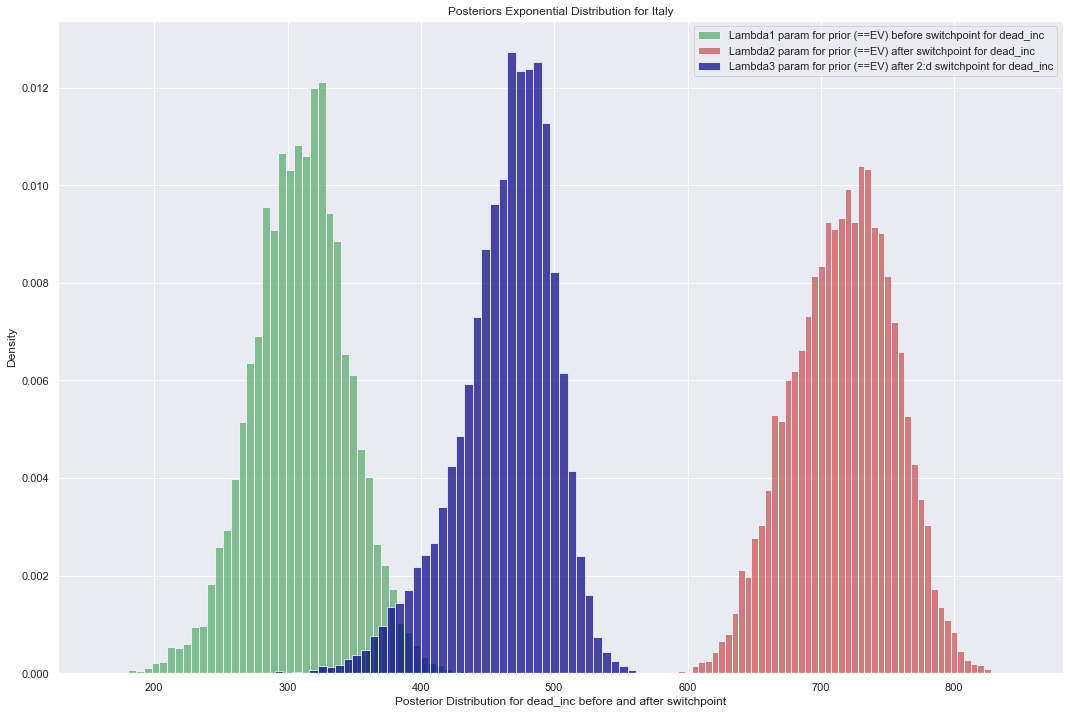

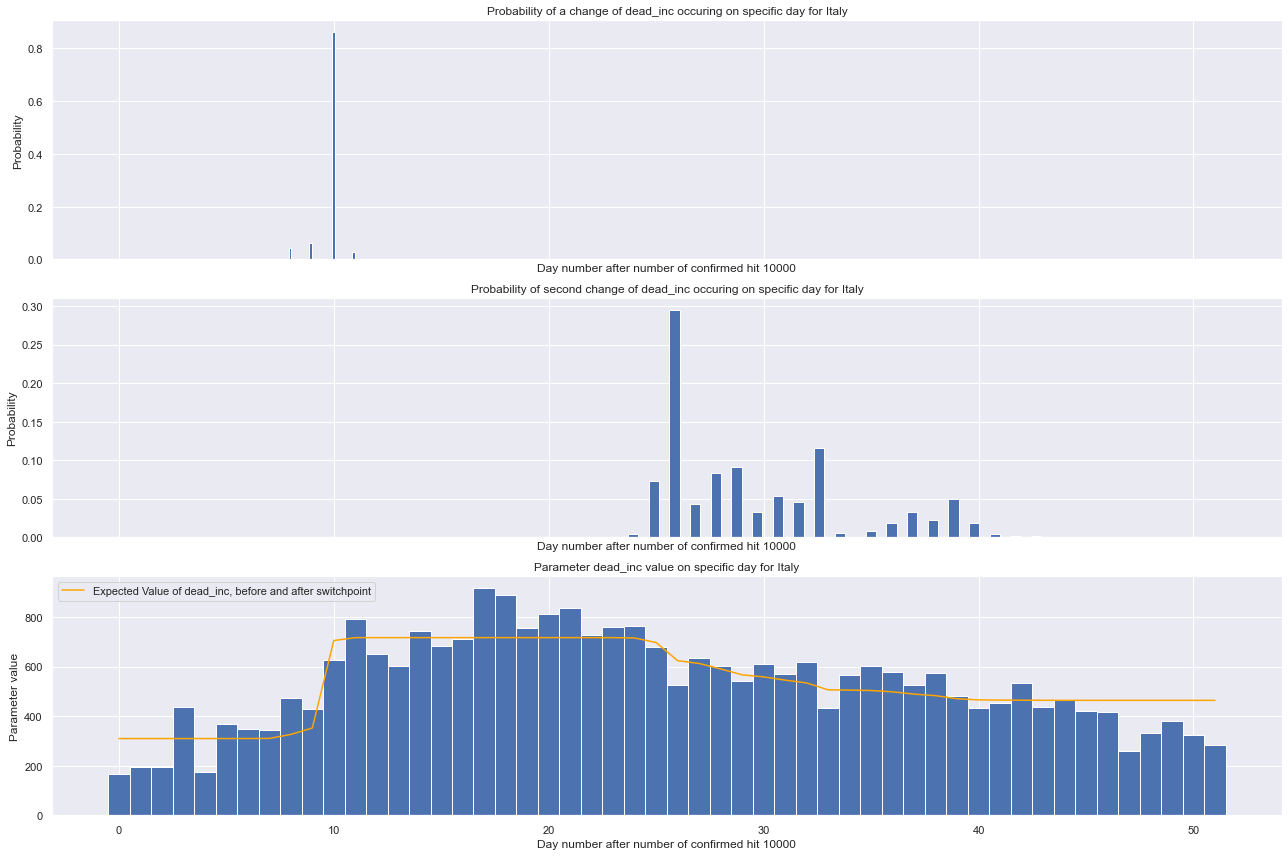

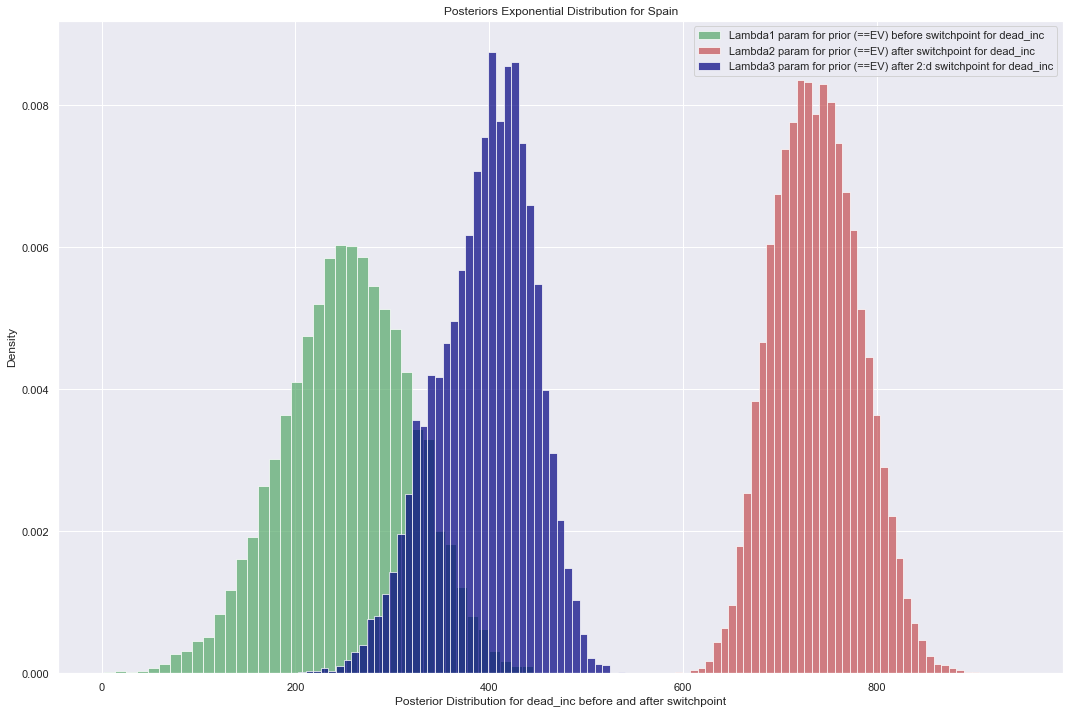

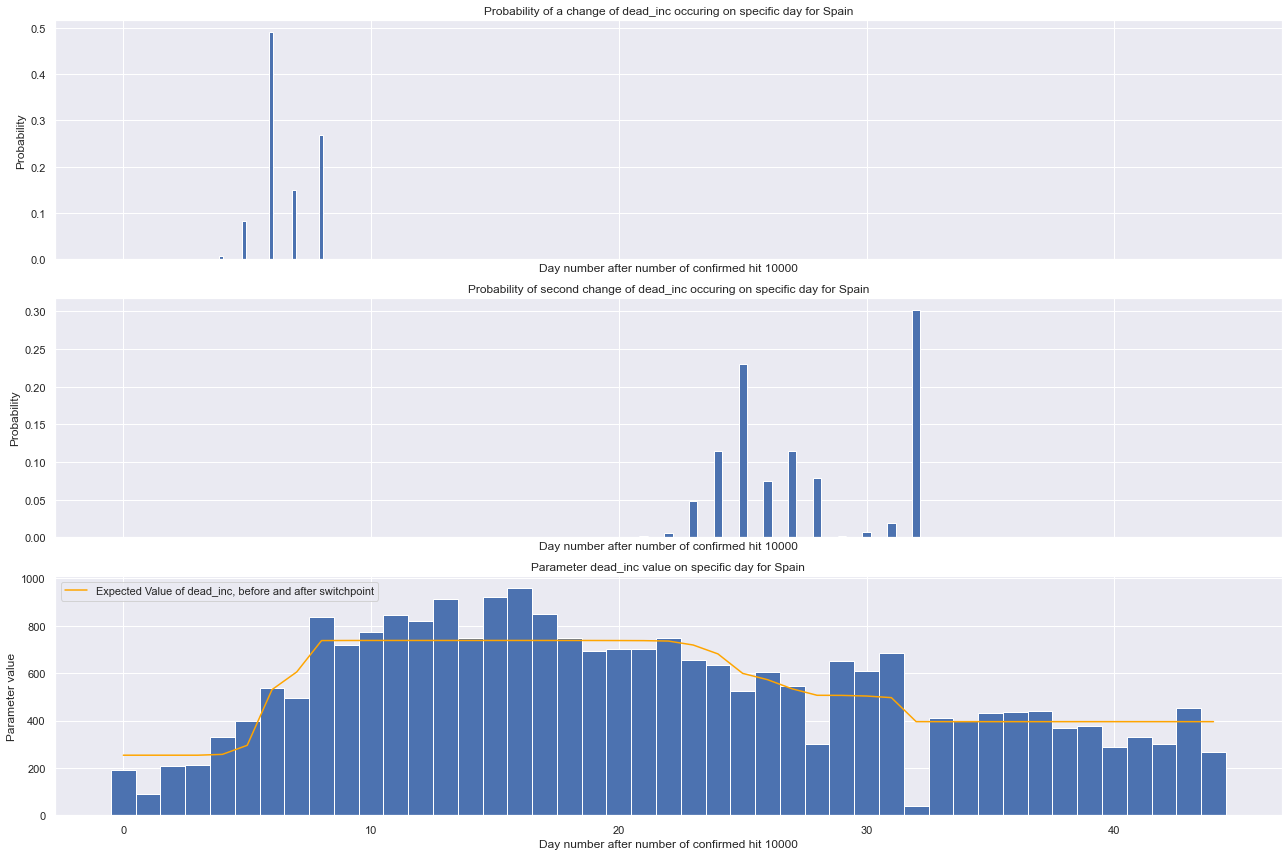

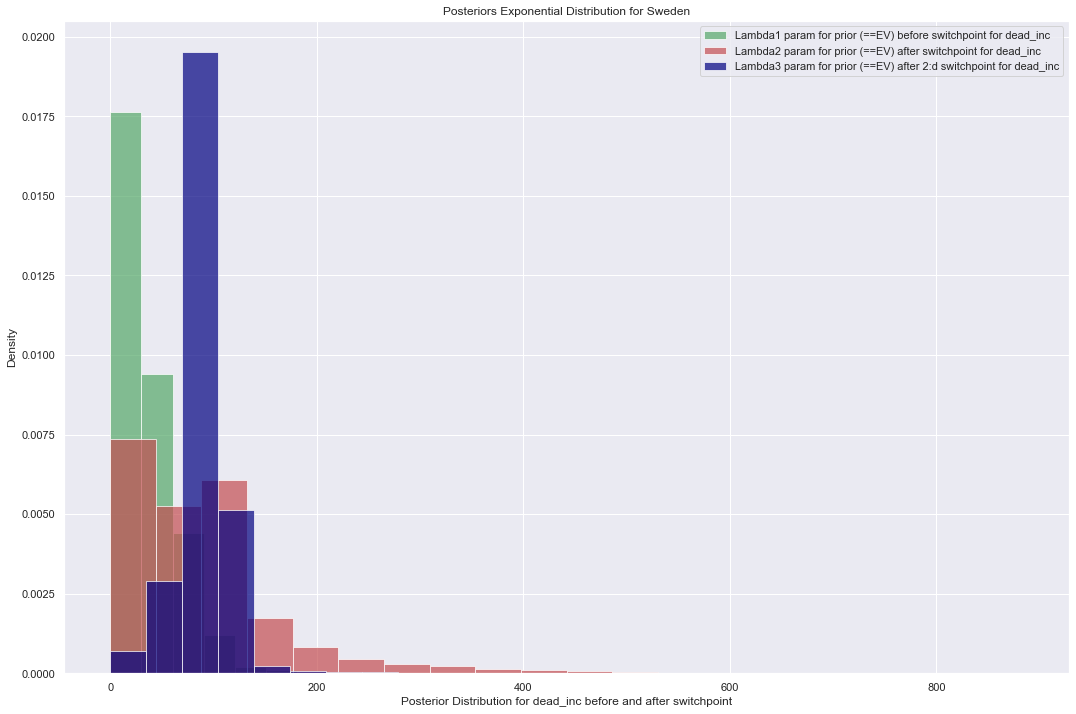

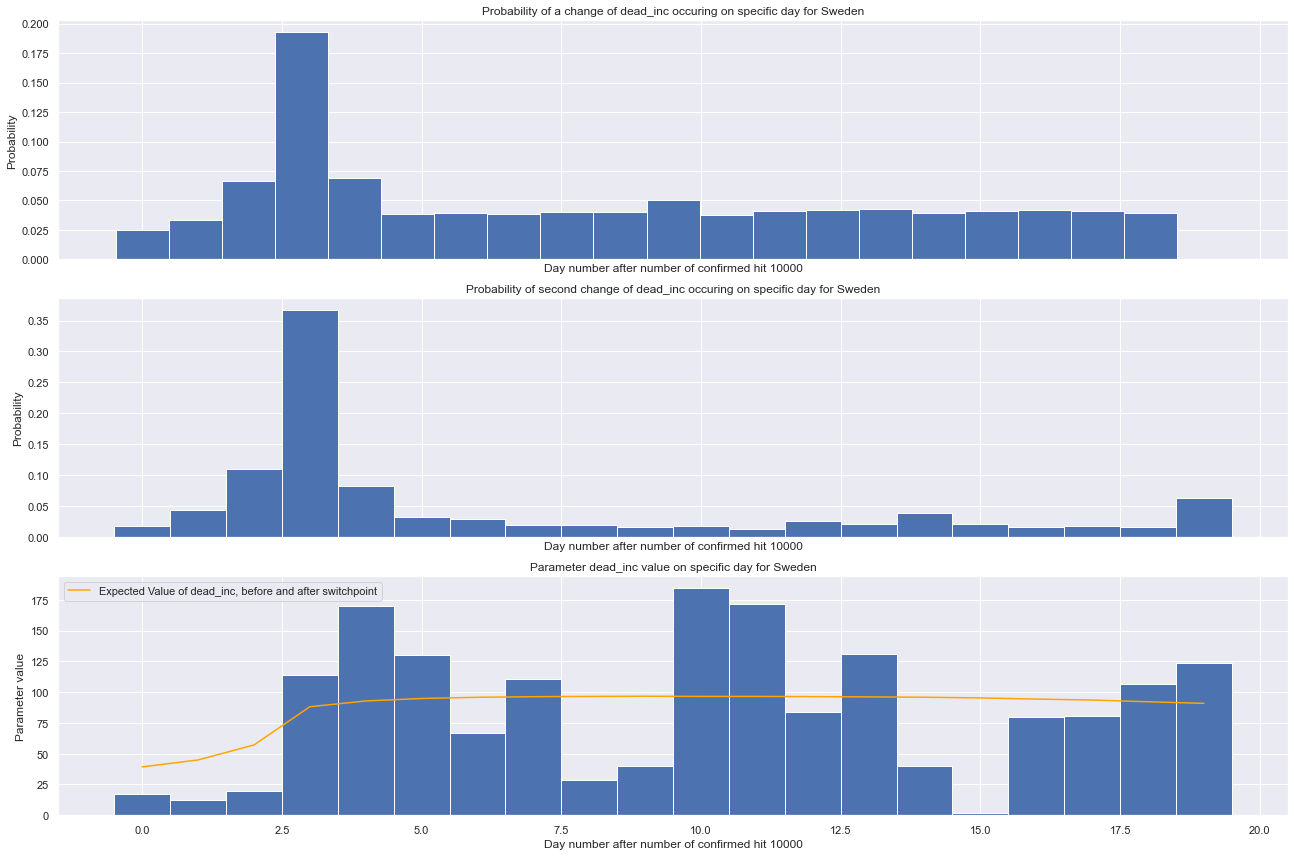

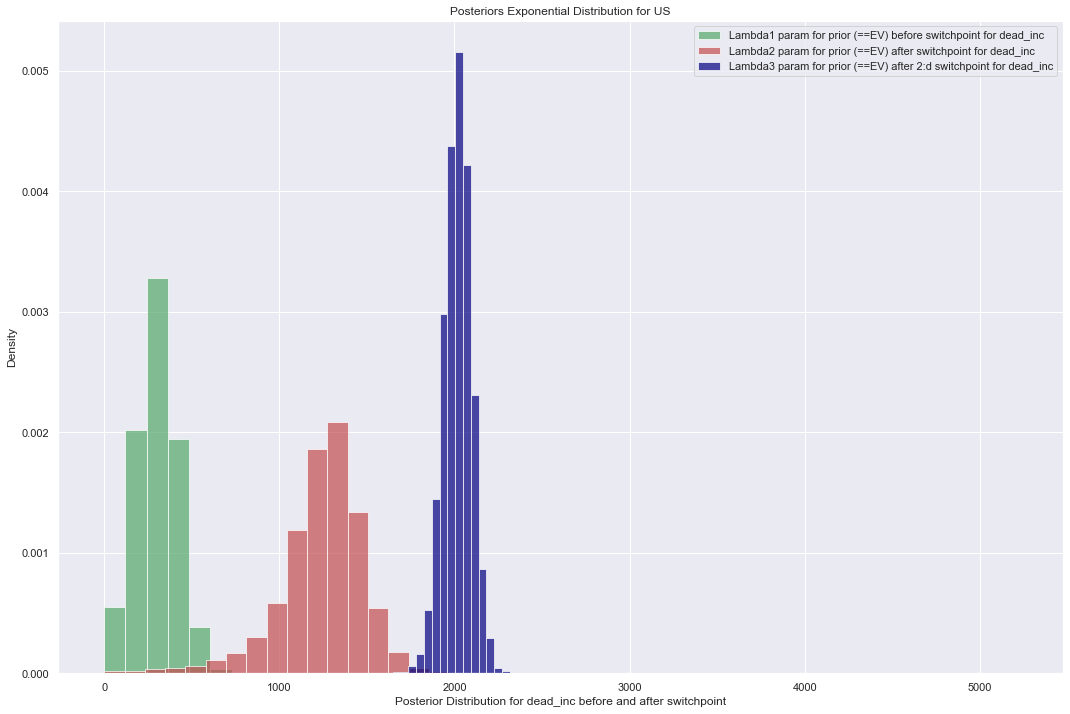

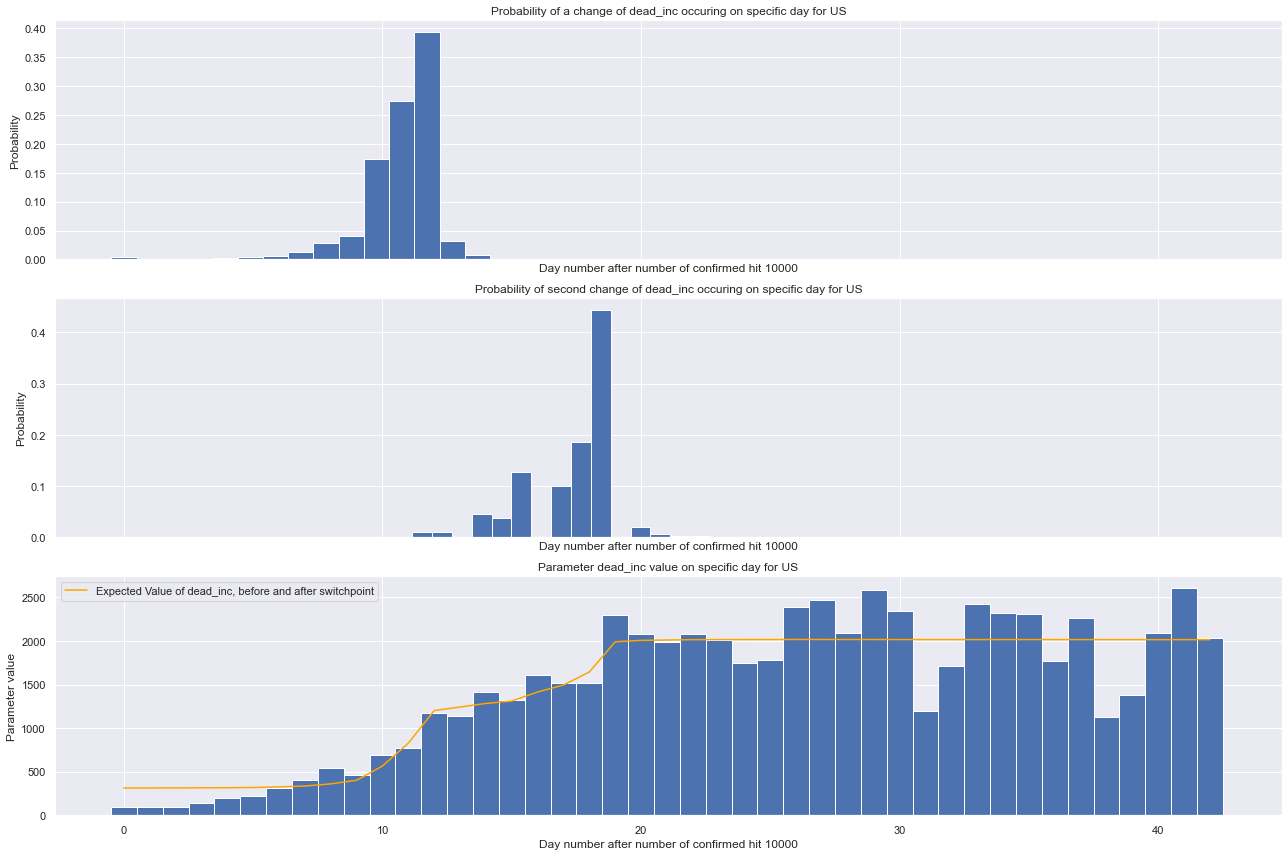

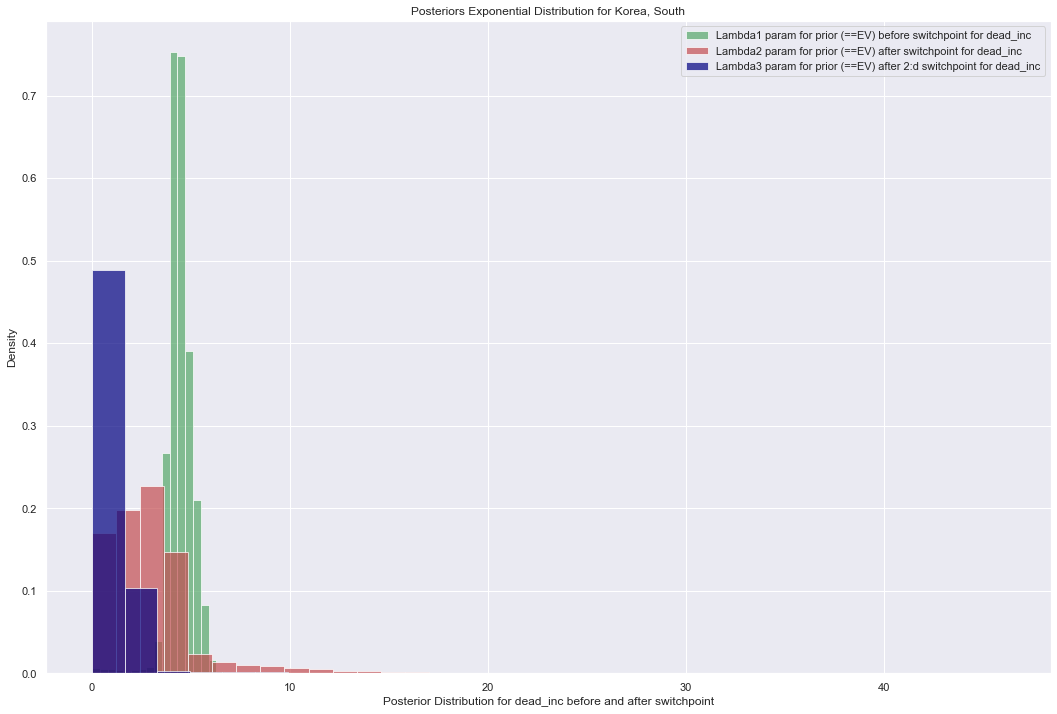

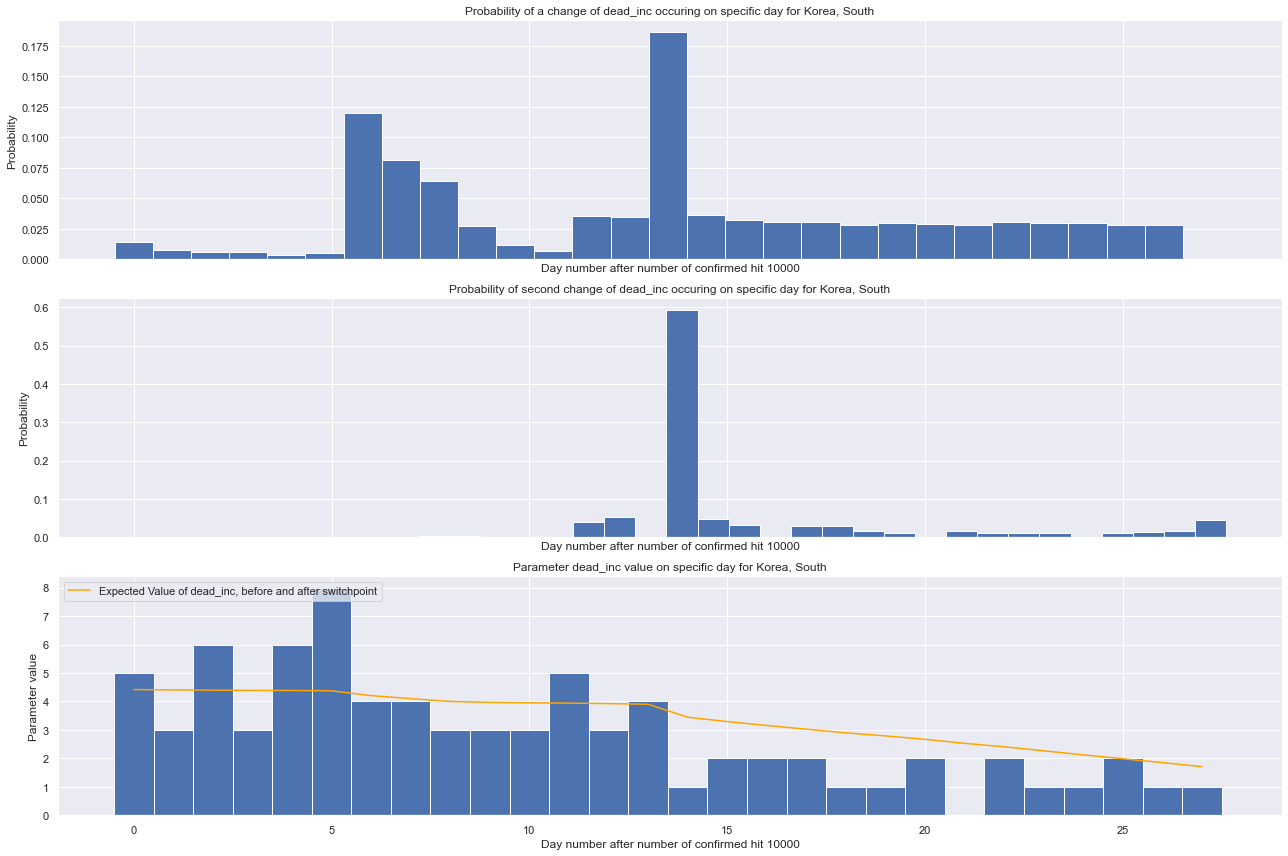

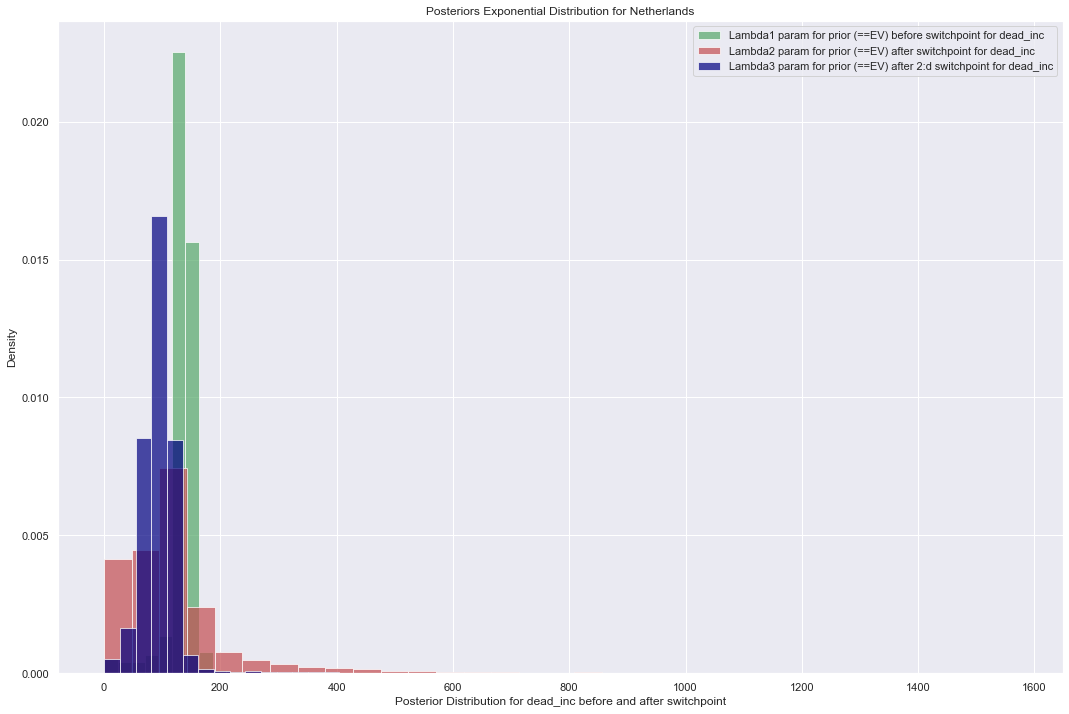

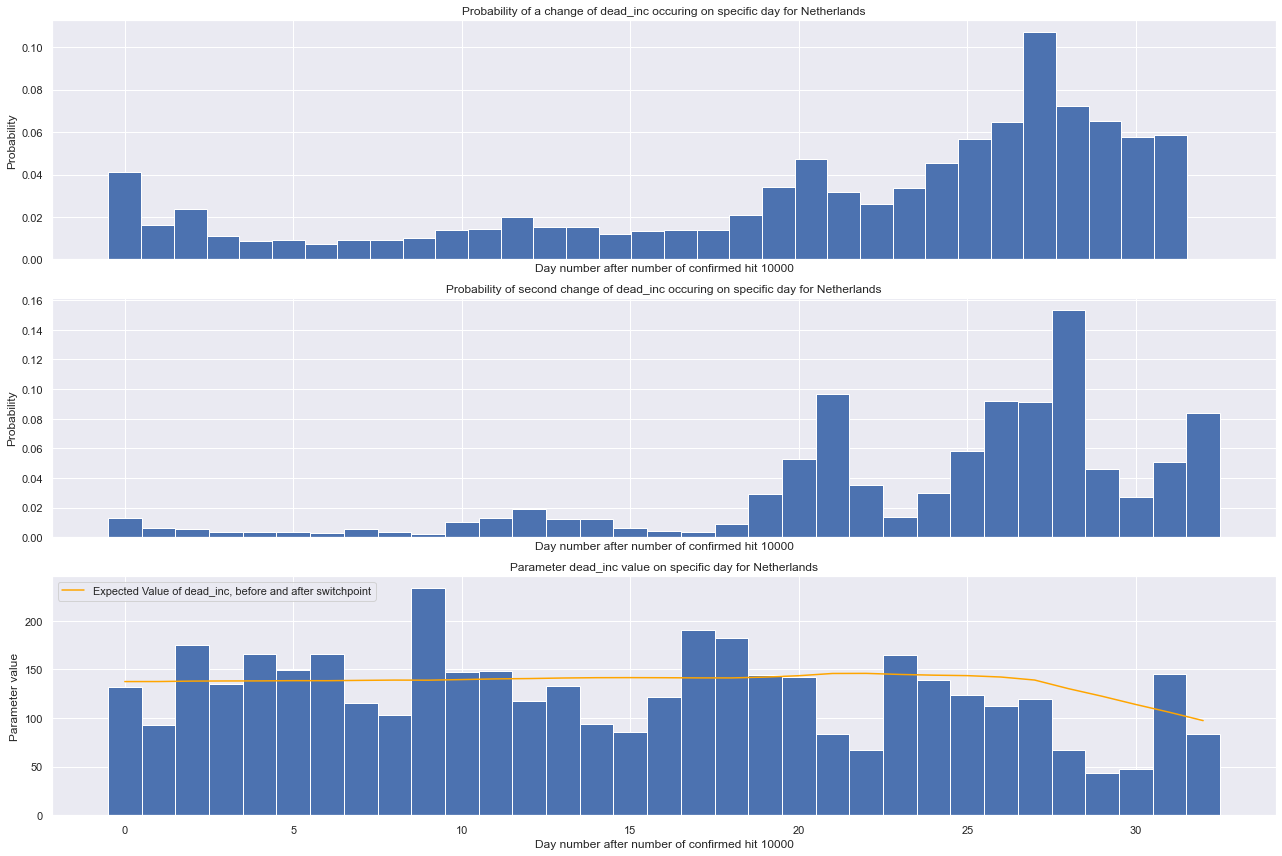

In [4]:
dick = pd.read_pickle('country_data.pkl')

def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})


countries = ['Italy','Spain','Sweden','US','Korea, South','Netherlands','Germany']
#countries = ['Italy','Spain']

#limit = 10 # first 10 days after passing 5 deceased

filter = 10000

for country_name in countries:

    df = dick[country_name]  
    
    population = country_populations.loc[country_name,'population']
    df['conf_per_M'] = df['confirmed'] / (population / 1e6)
    df['dead_per_M'] = df['deceased'] / (population / 1e6)
    
    df['factor_ratio'] = df['dead_factor'] / df['factor']
    
    ####### SCALE UP FACTOR for better resolution #######
    df['factor'] *= 100 # scaling up provides better resolution, apparently
    df['dead_factor'] *= 100
    ####### 

    df['day_nr'] = np.arange(len(df))

    mask = df['confirmed'] > filter
    
    df = df[mask].copy()
    df['day_nr'] = np.arange(len(df))

    df = df[~df.duplicated('confirmed',keep='first')]
    #df = df[:limit]
    
    print()
    print ('++++++++++   {}   +++++++++++'.format(country_name))
    #print (df.tail(20))
    
    param = 'dead_inc'
    
    #patch missing days
    print ('missing day')
    miss = pd.date_range(start = df.index[0], end = df.index[-1] ).difference(df.index)
    
    if len(miss):
        print (miss[0])
        print()
    
        day_before_miss = miss - pd.to_timedelta(1,unit='day')
        print (day_before_miss)
    
        df.at[miss[0],: ] = df.loc[day_before_miss[0],:]
    
        df.sort_index(inplace=True)
        df['day_nr'] = np.arange(len(df))
    
    print (df)
    data = df[param]
    
    result = switchpoint(data,country_name)
    if result is not None:
        plot(data,df,result,param,country_name)


In [ ]:
print ((result.lambda_2_post > result.lambda_1_post).mean())

In [ ]:
us_dick = pd.read_pickle('us_state_dict.pkl')
ny = us_dick['New York']
ny['factor'] *= 100 # scale up

ny = ny[ny['confirmed'] > 10000]
ny = ny.reset_index(inplace=False)

ny['day_nr'] = np.arange(len(ny))

param = 'dead_inc'
data = ny[param]

result = switchpoint(data,'New York')
plot(data,ny,result,param,'New York')

print (ny.tail(40))